In [1]:
# !jupyter nbconvert --to html /content/NN_DFO.ipynb

In [ ]:
#@title Imports
from statistics import mean
from sklearn.datasets import load_iris
import numpy as np
from numpy import loadtxt
import pandas as pd
from random import seed
!python -m pip install scikeras
from scikeras.wrappers import KerasClassifier

# from keras.models import Sequential
from tensorflow.keras.models import Sequential

# from keras.layers import Dense
from tensorflow.keras.layers import Dense

import time
# from keras import layers
from tensorflow.keras import layers

from keras.utils import plot_model
from keras.losses import BinaryCrossentropy

# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
import warnings
warnings.filterwarnings('ignore')

from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import numpy as np
from statistics import mean
from statistics import median
from statistics import stdev
import matplotlib.pyplot as plt
import math as m
import time
import pandas as pd
import time

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [3]:
#@title Neural Network
class neuralnet:
    def __init__(self, file):
        self.file = file
        self.epochs, self.batch_size, self.neurons, self.learning_rate = [None] * 4
        self.dataframe = None
        self.dataset = None
        self.model = None

        self.scores = None
        self.opt = None
        self.X, self.Y = [None] * 2
        self.x_train, self.x_test, self.y_train, self.y_test = [None] * 4

        print("--------------------------------------------------------")
        print("File Name: ", self.file)

    def params_initialisation(self, data_array):
        # initialises the data array with 4 parameters to be fine-tuned
        e, bs, ns, lr = data_array
        self.epochs, self.batch_size, self.neurons = int(e), int(bs), int(ns)
        self.learning_rate = float(lr)

    # __________________________________________________________________________________________________

    def data_pre_processing(self):
        # Receives the data (csv file) and normalises
        # the data as it is good machine learning practice

        self.dataframe = pd.read_csv(str(self.file))
        # self.dataframe.loc[self.dataframe['Result'] == -1] = 0

        ###################################################################
        features = self.dataframe.columns.tolist()
        features.remove('Result')

        self.X = self.dataframe[features].to_numpy()
        self.Y = self.dataframe['Result'].to_numpy()
        ###################################################################

        self.x_train, self.x_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.Y, test_size=0.30,
                             random_state=108, shuffle=True)  # stratify=self.Y

        ###################################################################
        # define min max scaler
        scaler = MinMaxScaler()
        # transform data
        x_train_sca = scaler.fit_transform(self.x_train)
        x_test_sca = scaler.transform(self.x_test)

        self.x_train = x_train_sca
        self.x_test = x_test_sca

        # define min max scaling for y
        scaler_y = MinMaxScaler()
        y_train_scaled = scaler_y.fit_transform(np.array(self.y_train).reshape(-1, 1))
        y_test_scaled = scaler_y.transform(np.array(self.y_test).reshape(-1, 1))

        self.y_train = np.array(y_train_scaled).reshape(1, -1)[0]
        self.y_test = np.array(y_test_scaled).reshape(1, -1)[0]

        self.X = np.concatenate([self.x_train, self.x_test], axis=0)
        self.Y = np.concatenate([self.y_train, self.y_test], axis=0)

    # __________________________________________________________________________________________________

    def create_model(self):
        seed(1)
        # Model is produced according to the requirements of the program
        self.model = Sequential()
        # model.add(Dense(128, activation='relu', input_shape=(30,)))
        self.model.add(Dense(self.neurons, input_shape=(30,), activation='relu'))  # dynamic value of neurons
        self.model.add(Dense(30, activation='relu'))  # fixed value of neurons
        self.model.add(Dense(1, activation='sigmoid'))

        # optimizer modification
        self.opt = Adam(learning_rate=self.learning_rate,)
        # self.opt = SGD(learning_rate=self.learning_rate)
        # compile model
        self.model.compile(loss='binary_crossentropy', optimizer=self.opt, metrics=['accuracy'])

        return self.model

    # __________________________________________________________________________________________________

    def wrapping_model(self, ready_model):
        # This function implements the wrapper classifier on the model for further processing
        kfcv = StratifiedKFold(n_splits=10, shuffle=True,) # random_state=108)

        neural_network = KerasClassifier(model=ready_model, epochs=self.epochs,
                                         batch_size=self.batch_size,
                                         verbose=0,) # random_state=108)
        scoring = ['accuracy', 'precision', 'recall', 'f1']
        self.scores = cross_validate(neural_network, self.x_train, self.y_train,
                                     scoring=scoring, cv=kfcv, return_train_score=True, verbose=0)

        return self.scores['test_accuracy']

    # __________________________________________________________________________________________________

    def dfo_model(self, mod):
        # This function is utilised for fine-tuning the DFO algorithm
        # with the help of the above model structure
        kfcv = StratifiedKFold(n_splits=10, shuffle=True,) # random_state=108)

        neural_network = KerasClassifier(model=mod, epochs=self.epochs,
                                         batch_size=self.batch_size,
                                         verbose=0,) # random_state=108)
        scoring = ['accuracy', 'precision', 'recall', 'f1']
        self.scores = cross_validate(neural_network, self.x_train, self.y_train, cv=kfcv, scoring=scoring,
                                     return_train_score=True, verbose=0,)
        # acc = self.scores['test_f1']

        return self.scores['test_accuracy']

    # __________________________________________________________________________________________________

    @staticmethod
    def visualize(accu):
        data = {"Baseline Neural Network": list(accu)}
        df = pd.DataFrame(data)
        df.boxplot(column=["Baseline Neural Network"])
        plt.show()

    def pred(self, mod):
        mod.fit(self.x_train, self.y_train, verbose=0, epochs=self.epochs, batch_size=self.batch_size)
        y_pred = mod.predict(self.x_test)
        rounded = [round(x[0]) for x in y_pred]
        acc_sc = accuracy_score(self.y_test, rounded)
        print("\n", "Neural Network Model Prediction: ",  acc_sc)

In [4]:
#@title DFO
class dfo:
    def __init__(self, n, d, delta, maxIt, X, fit, data_file,):
        self.N, self.D, self.delta, self.maxIterations, \
        self.X, self.fitness = n, d, delta, maxIt, X, fit
        self.file = data_file

        self.best_cost = np.empty(self.maxIterations)

        self.epochs = [int] * self.N
        self.batch_size = [int] * self.N
        self.neurons = [int] * self.N
        self.learning_rate = [int] * self.N

        self.data = None
        self.accuracy_data = np.empty([self.N, 10])

        self.invoke = neuralnet(self.file)
        self.invoke.data_pre_processing()

    # __________________________________________________________________________________________________

    def generate_data(self):
        for index in range(self.N):
            self.epochs[index] = (np.random.random() * 100) + 100
            self.batch_size[index] = ((np.random.random() * 100) / 2) + 10
            self.neurons[index] = ((np.random.random() * 100) / 2) + 10
            self.learning_rate[index] = (0.5 * np.random.random()) + 1e-04

        self.data = np.asarray(list(zip(map(int, self.epochs), map(int, self.batch_size),
                                        map(int, self.neurons), self.learning_rate)))
        self.X = self.data
        return self.data

    # __________________________________________________________________________________________________
    @staticmethod
    def random_epochs():
        return (np.random.random() * 100) + 100

    # __________________________________________________________________________________________________
    @staticmethod
    def random_batch_size():
        return ((np.random.random() * 100) / 2) + 10

    # __________________________________________________________________________________________________
    @staticmethod
    def random_neurons():
        return ((np.random.random() * 100) / 2) + 10

    # __________________________________________________________________________________________________
    @staticmethod
    def random_rate():
        return (0.5 * np.random.random()) + 1e-04

    # __________________________________________________________________________________________________
    def loop(self):
        # Most important section of the code
        # Fine-tuning the parameters takes place over here,
        # where the initialised data is sent to the NN model for evaluation
        # and returns with the Accuracy or F1 Score of classification

        for itr in range(self.maxIterations):
            for i in range(self.N):  # EVALUATION
                self.invoke.params_initialisation(self.data[i])
                model = self.invoke.create_model()

                accuracies = self.invoke.dfo_model(model)
                self.fitness[i] = mean(accuracies)

            s = np.argmax(self.fitness)  # FIND BEST FLY INDEX

            # Print details at every iteration
            if itr % 1 == 0:
                print("--------------------------------------------------------")
                print("Iteration:", itr, " Best fly index:", s,
                      "\nFitness Accuracy:", self.fitness[s],
                      "\nEpoch: ", self.data[s, 0], " Batch_size", self.data[s, 1],
                      "\nNeurons:", self.data[s, 2], " learning_rate: ", self.data[s, 3])

            # TAKE EACH FLY INDIVIDUALLY
            for i in range(self.N):
                if i == s:
                    continue  # ELITIST STRATEGY

                # FIND BEST NEIGHBOUR
                left = (i - 1) % self.N
                right = (i + 1) % self.N
                # initial eqn
                # bNeighbour = right if self.fitness[right] < self.fitness[left] else left
                # modified eqn
                bNeighbour = right if self.fitness[right] > self.fitness[left] else left

                for d in range(self.D):  # UPDATE EACH DIMENSION SEPARATELY
                    if d == 0 and np.random.random() < self.delta:
                        self.data[i, d] = self.random_epochs()
                        continue
                    if d == 1 and np.random.random() < self.delta:
                        self.data[i, d] = self.random_batch_size()
                        continue
                    if d == 2 and np.random.random() < self.delta:
                        self.data[i, d] = self.random_neurons()
                        continue
                    if d == 3 and np.random.random() < self.delta:
                        self.data[i, d] = self.random_rate()
                        continue

                    u = np.random.rand()
                    self.data[i, d] = self.data[bNeighbour, d] + u * (self.data[s, d] - self.data[i, d])

                    # OUT OF BOUND CONTROL
                    if d == 0 and not(100 <= self.data[i, 0] <= 200):
                        self.data[i, 0] = self.random_epochs()
                    if d == 1 and not(10 <= self.data[i, 1] <= 60):
                        self.data[i, 1] = self.random_batch_size()
                    if d == 2 and not(10 <= self.data[i, 2] <= 60):
                        self.data[i, 2] = self.random_neurons()
                    if d == 3 and not(1e-04 <= self.data[i, 3] <= 0.5 + 1e-04):
                        self.data[i, 3] = self.random_rate()

            self.best_cost[itr] = self.fitness[s]

    # __________________________________________________________________________________________________
    def evaluate(self):
        # Evaluation of the Data array to produce better results
        for i in range(self.N):
            self.invoke.params_initialisation(self.data[i])
            model = self.invoke.create_model()

            accu_list = self.invoke.dfo_model(model)
            self.fitness[i] = mean(accu_list)

            # The following line (accuracy data) saves the 10-fold accuracy of every
            # data point (4 values), and later return the array of 10-kfcv which
            # has the best accuracy s.
            self.accuracy_data[i] = list(accu_list)
        s = np.argmax(self.fitness)  # FIND BEST FLY
        print("--------------------------------------------------------")
        print("Final best fitness:\t", self.fitness[s])
        print("Best fly index:\t", s)
        print("Epoch: ", self.data[s, 0], " Batch_size", self.data[s, 1],
              "\nNeurons:", self.data[s, 2], " learning_rate: ", self.data[s, 3])

        return self.accuracy_data[s]

    # __________________________________________________________________________________________________
    def best_plot(self, acc):
        data = {"DFO": list(acc)}
        df = pd.DataFrame(data)

        df.boxplot(column=["DFO"])
        plt.show()

    # __________________________________________________________________________________________________
    def dfo_progression(self):
        # plt.plot(self.best_cost)
        plt.semilogy(self.best_cost)
        plt.title('Model Fitness Progression Analysis')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.show()

In [5]:
#@title Machine Learning Classifiers


class ml_classifiers:
    def __init__(self, file):

        #############################################################

        self.dataframe = pd.read_csv(str(file))
        features = self.dataframe.columns.tolist()
        features.remove('Result')

        self.X = self.dataframe[features].to_numpy()
        self.Y = self.dataframe['Result'].to_numpy()
        ####################################
        self.x_train, self.x_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.Y, test_size=0.20, )
        ####################################
        # define min max scaler
        scaler_x = MinMaxScaler()
        # transform data
        x_train_sca = scaler_x.fit_transform(self.x_train)
        x_test_sca = scaler_x.transform(self.x_test)

        self.x_train = x_train_sca
        self.x_test = x_test_sca

        # define min max scaling for y
        scaler_y = MinMaxScaler()
        y_train_scaled = scaler_y.fit_transform(np.array(self.y_train).reshape(-1, 1))
        y_test_scaled = scaler_y.transform(np.array(self.y_test).reshape(-1, 1))

        self.y_train = np.array(y_train_scaled).reshape(1, -1)[0]
        self.y_test = np.array(y_test_scaled).reshape(1, -1)[0]

        self.X = np.concatenate([self.x_train, self.x_test], axis=0)
        self.Y = np.concatenate([self.y_train, self.y_test], axis=0)

    # __________________________________________________________________________________________________

    def Naive_Bayes(self):
        # Naive Bayes
        nb_class = GaussianNB()
        cv = StratifiedKFold(n_splits=10, shuffle=True)
        scoring = ['accuracy', 'precision', 'recall', 'f1']
        score = cross_validate(nb_class, self.X, self.Y, cv=cv, scoring=scoring, return_train_score=True)
        nb_acc = score['test_accuracy']
        # nb_acc = score['test_f1']
        return nb_acc

    # __________________________________________________________________________________________________

    def Logistic_Regression(self):
        # Random Forest
        rf_class = LogisticRegression()
        cv = StratifiedKFold(n_splits=10, shuffle=True)
        scoring = ['accuracy', 'precision', 'recall', 'f1']

        score = cross_validate(rf_class, self.X, self.Y, cv=cv, scoring=scoring, return_train_score=True)
        lr_acc = score['test_accuracy']
        # lr_acc = score['test_f1']
        return lr_acc

In [ ]:
def show(nn_ac, dfo_ac, nb_acc, lr_acc):
    data = {"Baseline Neural Network": list(nn_ac), "DFO": list(dfo_ac),
            "Naive Bayes": list(nb_acc), "Logistic Regression": list(lr_acc)}
    df = pd.DataFrame(data)
    df.boxplot(column=["Baseline Neural Network", "DFO",
                       "Naive Bayes", "Logistic Regression"])
    plt.title("Machine Learning Models Comparison")
    plt.xlabel('Models')
    plt.ylabel('Accuracy obtained')
    plt.show()

################################################################################
# Random Training Sessions

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# import tensorflow as tf

nn_data_file = 'Training_30_11000.csv'
epochs = 100
batch_size = 40
neurons = 25
###########################
# For SGD, higher Learning Rate gives better results.
# For Adam, lower Learning Rate gives better results.
###########################
learning_rate = 0.001  # 0.1 (SGD), 0.001 (Adam)
call = neuralnet(nn_data_file)

start = time.time()

call.params_initialisation([epochs, batch_size, neurons, learning_rate])
call.data_pre_processing()
model = call.create_model()
neural_network_accuracy = call.wrapping_model(model)

end = time.time()
print("--------------------------------------------------------")
print("Accuracy: ", neural_network_accuracy, f"\nMean:  {mean(neural_network_accuracy)*100:.4f}")
print(f"\nTime taken: {end-start:.4f} seconds")
call.pred(model)

################################################################################
# Random Training Sessions
N = 7  # POPULATION SIZE
D = 4  # DIMENSIONALITY
delta = 0.01     # DISTURBANCE THRESHOLD
maxIterations = 20  # ITERATIONS ALLOWED

X = np.empty([N, D])  # EMPTY FLIES ARRAY OF SIZE: (N,D)
fitness = [None] * N  # EMPTY FITNESS ARRAY OF SIZE N

start = time.time()

dfo_data_file = 'Training_30_2500.csv'
call = dfo(N, D, delta, maxIterations, X, fitness, dfo_data_file,)
call.generate_data()
call.loop()
dfo_accuracy = call.evaluate()
end = time.time()
print(f"\nTime taken: {(end-start)/60:.4f} minutes")
print('10 KFCV Accuracy: ', dfo_accuracy, 'Mean: ', mean(dfo_accuracy))
print('\nDFO BEST FITNESS ACCURACY PROGRESSION')
call.dfo_progression()



Data:  [[1.15797308e+02 4.27662906e+01 5.22735527e+01 4.65653515e-01]
 [1.15732544e+02 4.70755299e+01 4.14473051e+01 1.34657565e-02]
 [1.15754616e+02 4.70431669e+01 4.20265138e+01 1.36869776e-02]
 [1.15744217e+02 4.71155449e+01 4.17880669e+01 1.36219079e-02]
 [1.15744099e+02 3.76975526e+01 3.94108743e+01 1.31575545e-02]
 [1.15609287e+02 2.84391730e+01 3.75999353e+01 3.56341948e-01]
 [1.15585601e+02 2.66290578e+01 4.20827707e+01 2.52525417e-01]]

Best Fitness Costs:  [0.95404257 0.95753434 0.9621889  0.95812593 0.95463416 0.95520876
 0.95345777 0.9505508  0.95986332 0.95694954 0.95692914 0.95637155
 0.95811574 0.95579355 0.95927513 0.95755474 0.95579695 0.95928193
 0.95927173 0.95461376]


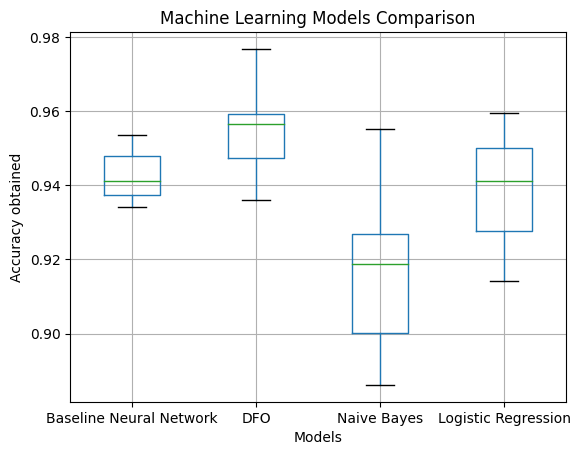

In [ ]:
print('\nData: ', call.data)
print('\nBest Fitness Costs: ', call.best_cost)

################################################################################
# Random training sessions
ml_class_file = 'Training_30_2500.csv'
invoke = ml_classifiers(ml_class_file)

naive_bayes_accuarcy = invoke.Naive_Bayes()
log_reg_accuracy = invoke.Logistic_Regression()

################################################################################

show(neural_network_accuracy, dfo_accuracy, naive_bayes_accuarcy, log_reg_accuracy)